## Data Pre-Processing 
- importing libraries and data  
- cleaning
- exploring
- merging
- weights feature calculation
- scaling weights
- comparing scaled ratings 
- comparing weights and scaled ratings density
- sparsity checking 
- poopularity based ranking of layouts

### importing libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import requests
from io import StringIO
import seaborn as sns
import glob

### Importing data

In [2]:
URL1 = 'https://drive.google.com/file/d/1R2whoZWVpLIZpaZpL9hzg89iDmy0pamp/view?usp=sharing'
path1 = 'https://drive.google.com/uc?export=download&id='+URL1.split('/')[-2]
df1 = pd.read_csv(path1)

URL2 = 'https://drive.google.com/file/d/11GJBM9hvJzHz8GLcefs8fflghtKItiBi/view?usp=sharing'
path2 = 'https://drive.google.com/uc?export=download&id='+URL2.split('/')[-2]
df2 = pd.read_csv(path2)

URL3 = 'https://drive.google.com/file/d/10of_7LOzuGpPkgv4hHhliHhNPY8jZFEx/view?usp=sharing'
path3 = 'https://drive.google.com/uc?export=download&id='+URL3.split('/')[-2]
df3 = pd.read_csv(path3)

URL4 = 'https://drive.google.com/file/d/1mJgAzNs01iX4wAk7hKSRgUZp4j2K9faR/view?usp=sharing'
path4 = 'https://drive.google.com/uc?export=download&id='+URL4.split('/')[-2]
df4 = pd.read_csv(path4)

URL5 = 'https://drive.google.com/file/d/1z5OMKuRrd8tWTFDA2RkVbBo1e0Kxo7us/view?usp=sharing'
path5 = 'https://drive.google.com/uc?export=download&id='+URL5.split('/')[-2]
df5 = pd.read_csv(path5)

URL6 = 'https://drive.google.com/file/d/1v-i8t7WH97rzVfbglJC5kDX2jAFDzkZW/view?usp=sharing'
path6 = 'https://drive.google.com/uc?export=download&id='+URL6.split('/')[-2]
df6 = pd.read_csv(path6)

df = df6.append([df1,df2,df3,df4,df5], ignore_index = True) 

- if above cell gives "not found 404" error 
    - uncomment below code it imports data from local directory

In [3]:
# def get_implicit_data():
#     filespath = 'datasets/users implicit feedback//'
#     df = pd.DataFrame()
#     all_files = glob.glob(filespath + "*.csv")
#     li = []
#     for filename in all_files:
#         df = pd.read_csv(filename, index_col=None, header=0)
#         li.append(df)
#     frame = pd.concat(li, axis=0, ignore_index=True)
#     return frame

# df = get_implicit_data()

## Analysing user behavioral data
## Data cleaning


- renaming, 
- changing time scaling,
- etc,

In [4]:
# updating user_ids
def change_user(df):
    user_dictionary = {}
    user_number = None
    for user_id in df.user_id.unique():
        if len(user_dictionary)==0:
            new_user = "u "+str(len(user_dictionary))
            df.loc[(df.user_id==user_id),'user_id']=new_user
            user_dictionary[user_id] = new_user
            print('old user_id: {}, new user_d'.format(user_id,new_user))
        if user_id not in user_dictionary.keys():
            new_user = "u "+str(len(user_dictionary))
            df.loc[(df.user_id==user_id),'user_id']=new_user
            user_dictionary[user_id] = (new_user)
        else :
            new_user = "u "+str(len(user_dictionary))
            df.loc[(df.user_id==user_id),'user_id']=new_user
            user_dictionary[user_id] = (new_user)
            
    return df,user_dictionary
df,user_dictionary = change_user(df)


old user_id: Ozqv3X1u3xdOeNJgeGIoVK72Lbr2, new user_d


In [5]:
df['engagement_time_seconds'] = df.engagement_time_msec/1000

In [6]:
# Renaming layouts 
def change_layouts(df):
    layout_dictionary = {}
    layout_number = 0
    for layout_id in df.firebase_screen.unique():
        if len(layout_id)>5:
            if len(layout_dictionary)==0:
                layout_number = 1
                new_layout = "GLHS"+(str(layout_number))
                layout_dictionary[layout_id] = new_layout
                df.loc[(df.firebase_screen==layout_id),'firebase_screen']=new_layout

            if layout_id not in layout_dictionary.keys():
                layout_number =layout_number+ 1
                #user_number+=len(user_dictionary.keys())
                new_layout = "GLHS"+(str(layout_number))
                layout_dictionary[layout_id] = new_layout
                df.loc[(df.firebase_screen==layout_id),'firebase_screen']=new_layout
            
            if layout_id in layout_dictionary.keys():
                #user_number+=len(user_dictionary.keys())
                new_layout = "GLHS"+(str(layout_number))
                layout_dictionary[layout_id] = new_layout
                df.loc[(df.firebase_screen==layout_id),'firebase_screen']=new_layout
                
        else:
            layout_dictionary[layout_id] = layout_id
        #print(layout_dictionary)
    return df,layout_dictionary

- removing unnecessary features and test examples

In [7]:
# droping unuseful features
df.drop(df.iloc[:, 11:23], inplace = True, axis = 1)
unnecessary_features = ['ITEM_GENRE','ITEM_POSITION_LIST','COLUMN']
df.drop(columns=unnecessary_features,inplace=True)

# screens used for testing so droping them 
unnecessary_screen = ['nullTab','homeFragment','ProductsCategory','HomeFragment','Map','Maps','HomeTab','productDetailsFragment']
df_new = pd.DataFrame()
for screen in unnecessary_screen:
    df = df[(df['firebase_screen']!=screen)& (~df['firebase_screen'].isna())]
df, layout_dictionary = change_layouts(df)

# drop engagement_time_millisecs
df.drop(['engagement_time_msec'], axis='columns', inplace=True)

# include only necessary and drop extra events 
unnecessary_event_names =  ['screen_view','user_engagement','select_content','select_item']
df = df.loc[(df.event_name.isin(unnecessary_event_names))]

# every layout/firebase_screen/view is hosted by an activity which is represented in firebase_screen_class(parent) so dop it
df.drop(columns=['firebase_screen_class'],inplace=True)

# some content was logged for testing so remove those too
test_content = ['Three_Col_Button','Home_Button','Map_Button']
df = df[~(df.event_name=='select_content')&~(df.content.isin(test_content))|~(df.content.isna())]

## Data Exploration
df feature firebase_screen contains fragments or views showing items in different number of rows and columns. which makes them grid layouts
we desiged 10 number of grid layouts. 5 of them are verticaly scrollable with 1 to 5 number of columns 
However, the rest are horizontally scrollable, with 1 to 5 number of rows
- vertically scrollable grid layouts (L1 to L5)
- horizontally scrollable grid layouts (GHLS1 to GHLS5)
- the integer number with the layout names refer to number of columns and rows, respectively
- more the number of columns and rows on a grid screen or view Less the information about movies is available on each ad
- if massive number of ads are visible on each view, smaller an ad's size would be. harder to create a successful target hit due to the fat fingure problem
- visually target search, detection and selection also takes time, But easy for expert users. those can easily manipulate the components and items on the layouts
- users' explicit selection of content and items, number of visits , and spent time in seconds on individual grid layout (layout)
- explaining features in data:
    - firebase_screen represents layouts, users are represented by their ids in user_id feature
    - event_name contains number of events triggered by the users, by selecting movies' ads or items and content, buttons or components
    - by adding number of occurrences of individual features and time spent by the users during interacting with layouts
    - creates a weight feature, that defines the magnitude of satisfaction of users over the layouts
- approaches for features scalling: 
    - min-max scaler 
    - standard scaler
    - max absolute scaler
    - Robust scaler (Interquartile Range IQR)

<AxesSubplot:xlabel='event_name', ylabel='counts of all events'>

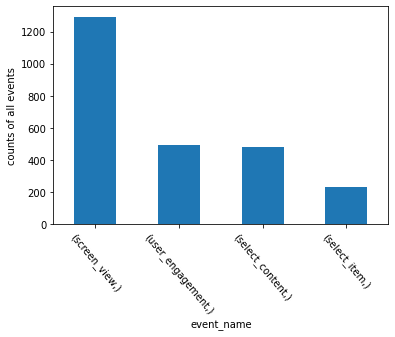

In [8]:
# number of occurances of individual logged events
fig, ax = plt.subplots(figsize=(6,4))
plt.ylabel("counts of all events")
ax = df.loc[(df['firebase_screen']!='productDetailsFragment'),['event_name']]
ax.value_counts().plot(kind='bar',rot=-50)

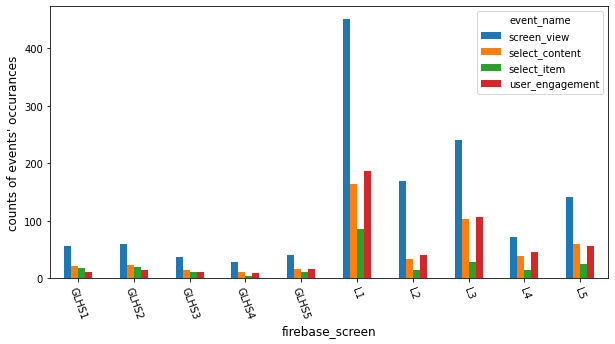

In [9]:
# number of individual event on each screen
fig, ax1 = plt.subplots(figsize=(10,5))
plt.xlabel("User id", fontsize=12)
plt.ylabel("counts of events' occurances", fontsize=12)
ax = df.groupby(['firebase_screen','event_name'])['event_name'].count().unstack().plot(kind='bar',rot=-70,ax=ax1)

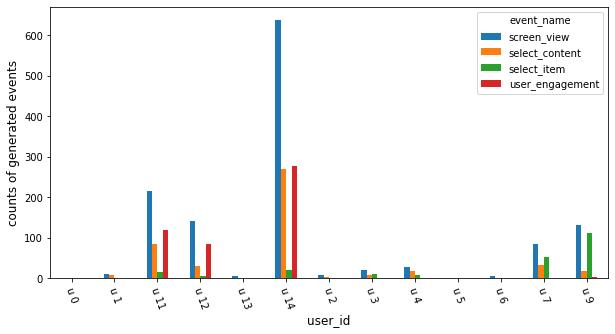

In [10]:
# number of times individual event triggered by the users
fig, ax1 = plt.subplots(figsize=(10,5))
plt.xlabel("User id", fontsize=12)
plt.ylabel("counts of generated events", fontsize=12)
ax = df.groupby(['user_id','event_name'])['event_name'].count().unstack().plot(kind='bar',rot=-70, ax=ax1)


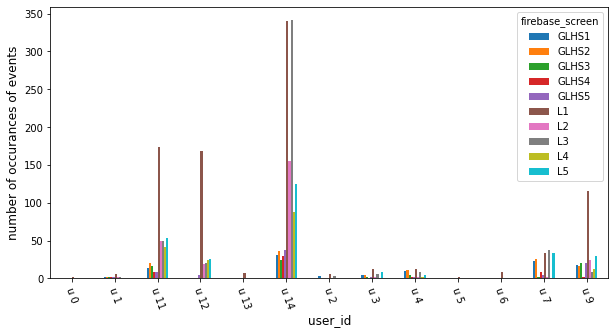

In [11]:
# number of times events triggered by the users on each screen
fig, ax1 = plt.subplots(figsize=(10,5))
plt.xlabel("User id", fontsize=12)
plt.ylabel("number of occurances of events", fontsize=12)
ax = df.groupby(['user_id','firebase_screen'])['event_name'].count().unstack().plot(kind='bar',rot=-70,ax=ax1)

<AxesSubplot:xlabel='user_id', ylabel='number of occurances of screen_view'>

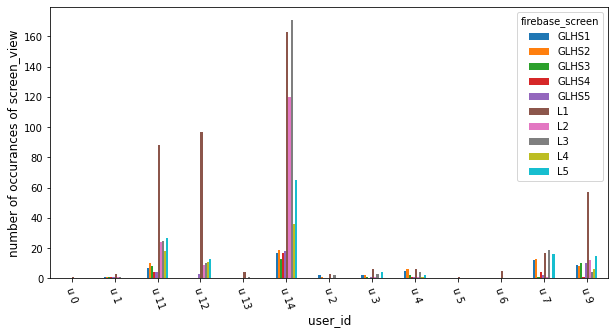

In [12]:
# number of times users triggered screen_view time or number of screen_view engagements
fig, ax1 = plt.subplots(figsize=(10,5))
plt.xlabel("User id", fontsize=12)
plt.ylabel("number of occurances of screen_view", fontsize=12)
ax = df.loc[(df['event_name']=='screen_view')].groupby(['user_id','firebase_screen'])['event_name']
ax.count().unstack().plot(kind='bar',rot=-70, ax=ax1)

<AxesSubplot:xlabel='user_id', ylabel='total time in seconds'>

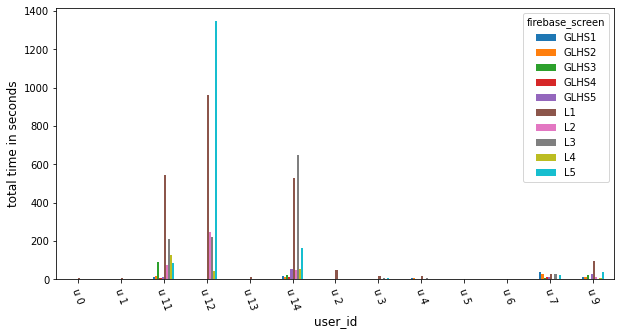

In [13]:
# total time in second spent by the users on each screen, recorded in screen_view event
fig, ax1 = plt.subplots(figsize=(6,5))
plt.xlabel("User id", fontsize=12)
plt.ylabel("total time in seconds", fontsize=12)
ax = df.loc[(df['event_name']=='screen_view')].groupby(['user_id','firebase_screen'])['engagement_time_seconds']
ax.sum().unstack().plot(kind='bar',ax=ax1,rot=-70, figsize=(10,5))

<AxesSubplot:xlabel='user_id', ylabel='total less time in seconds than mean'>

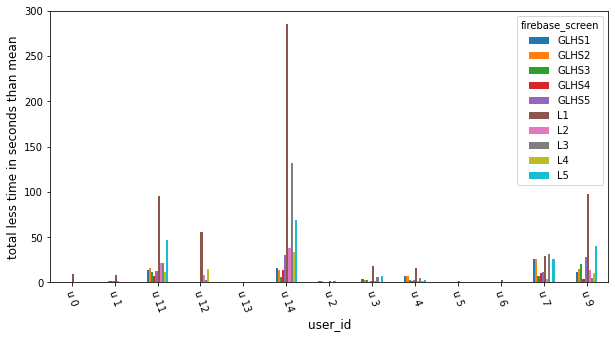

In [14]:
# users spent less total time in seconds than mean time of all users on each visited screen
fig, ax1 = plt.subplots(figsize=(6,5))
plt.xlabel("User id", fontsize=12)
plt.ylabel("total less time in seconds than mean", fontsize=12)
ax = df.loc[(df['engagement_time_seconds']<df['engagement_time_seconds'].mean())&
    (df['event_name']=='screen_view')].groupby(['user_id','firebase_screen'])['engagement_time_seconds']
ax.sum().unstack().plot(kind='bar', ax=ax1,rot=-70, figsize=(10,5))

<AxesSubplot:xlabel='user_id', ylabel='total time in seconds'>

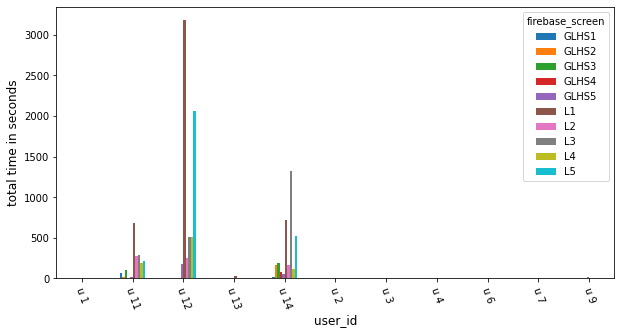

In [15]:
# total time in seconds spent by the users before destroying current activity/layout/screen of the application
fig, ax1 = plt.subplots(figsize=(6,5))
plt.xlabel("User id", fontsize=12)
plt.ylabel("total time in seconds", fontsize=12)
ax = df.loc[(df['event_name']=='user_engagement')].groupby(['user_id','firebase_screen'])['engagement_time_seconds']
ax.sum().unstack().plot(kind='bar',rot=-70, ax= ax1, figsize=(10,5))

# Pre-processing

## Screen_View Event
- creating screen_view dataframe
    - adding total time in second spent by each user on individual screen/layout
    - count the number of screen_view events
    - creating feature "all_view_engagement_time_sum" and "screen_view_count"
    - drop the duplicates and keep the first user-screen interactions 
    - drop the useless features 

In [16]:
screen_view_df = df.loc[(df['event_name']=='user_engagement')|(df['event_name']=='screen_view'),['user_id','event_name','firebase_screen','engagement_time_seconds']]
screen_view_df['all_view_engagement_time_sum'] = screen_view_df.groupby(['user_id','firebase_screen'])['engagement_time_seconds'].transform('sum')
screen_view_df['screen_view_count'] = screen_view_df[(df['event_name']=='screen_view')].groupby(['user_id','firebase_screen'])['event_name'].transform('count')
screen_view_df = screen_view_df.drop_duplicates(subset=['user_id','firebase_screen','screen_view_count','all_view_engagement_time_sum'], keep='first') 
screen_view_df = screen_view_df.drop(['engagement_time_seconds'],axis = 1)

C:\Users\MUHAMM~1\AppData\Local\Temp/ipykernel_22684/105404794.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  screen_view_df['screen_view_count'] = screen_view_df[(df['event_name']=='screen_view')].groupby(['user_id','firebase_screen'])['event_name'].transform('count')


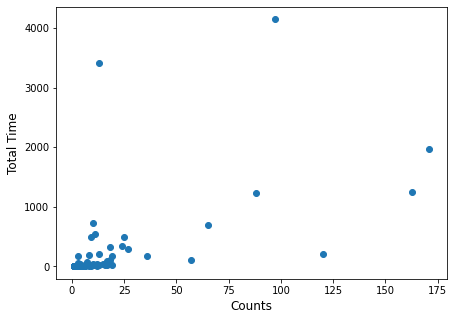

In [17]:
# counts of occurances of screen_view events and total engagement duration in seconds
screen_view_df = screen_view_df.reset_index(drop=True)
screen_view_df['event_name']='screen_view'
fig, ax = plt.subplots(figsize=(7,5))
plt.xlabel('Counts', fontsize=12)
plt.ylabel('Total Time', fontsize=12)
plt.scatter(screen_view_df.screen_view_count,screen_view_df.all_view_engagement_time_sum)

- considering above plot outliers in the data are expected due to the huge time difference

   - Because we will consider the time in user engagement with the counts of screen_view events that is why no need to give any predefined weights
   - renaming the features
   - feature "all_view_engagement_time_sum" and "screen_view_count" are weights for screen_view 

In [18]:
screen_view_df['screen_view_counts'] = screen_view_df.screen_view_count*20 
screen_view_df = screen_view_df.rename(columns={'event_name':'event_screen_view'})
screen_view_df.describe()

,all_view_engagement_time_sum,screen_view_count,screen_view_counts
count,116.000000,80.000000,80.00000
mean,310.344586,16.162500,323.25000
std,753.184120,32.203641,644.07283
min,0.000000,1.000000,20.00000
25%,6.921000,1.000000,20.00000
50%,31.666000,5.000000,100.00000
75%,211.813000,13.500000,270.00000
max,4145.038000,171.000000,3420.00000


## Select_content Event
- creating dataframe "select_content_df"
- dataframe only contains data related to the select_content event 
    - renaming, replacing contents
    - renaming content types

In [19]:
select_content_df = df.loc[(df['event_name']=='select_content'),['user_id','event_name','firebase_screen','content_type','content']]

In [20]:
for content in select_content_df.content.unique(): 
    if content in list(layout_dictionary.keys()):
        select_content_df.loc[(select_content_df.content==content),'content'] = layout_dictionary[content]+'_Button'
select_content_df = select_content_df.replace({'content' : {'action_signOut':'SignOut_button',}})
select_content_df = select_content_df.replace({'content_type' : { 'BottomNavBar_Screen' : 'BottomNavBar', 'NavBar_Button' : 'BottomNavBar' }})

<AxesSubplot:title={'center':'number of times content selected by users on screens/layouts'}, xlabel='user_id', ylabel='counts of content'>

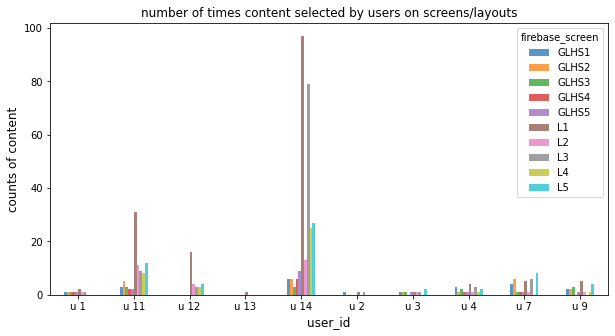

In [21]:
fig, ax = plt.subplots(figsize=(10,5))
plt.title("number of times content selected by users on screens/layouts")
plt.xlabel("User id", fontsize=12)
plt.ylabel("counts of content", fontsize=12)
select_content_df.groupby(['user_id','firebase_screen']).count()['content'].unstack().plot(kind = 'bar',ax=ax,alpha=0.75, rot=0)

- creating feature "count_layout_selection"
    - defines how many number of times the content was selected on visited screens by the users
    - counts of content event are computed
    - drop the duplicate rows and keep the first for each user layouts interaction for content activity 

In [22]:
select_content_df['count_layout_selection'] = select_content_df.groupby(['user_id','firebase_screen'])['content'].transform('count')
content_selection = select_content_df.drop_duplicates(subset=['user_id','firebase_screen'], keep='first') 
content_selection = content_selection.reset_index(drop=True)
select_content_df.describe()

,count_layout_selection
count,480.000000
mean,40.445833
std,38.214716
min,1.000000
25%,6.000000
50%,25.000000
75%,79.000000
max,97.000000


- if we want the users to interact with the application and layouts running on it then we expect that the users will generate as many events on layouts as possible except generating screen_view events and spending time.
- this is the things required to evaluate the users' behaviour on individual layout
- to find the magnitude of users' satisfaction on the visited layouts we assigned a predefined weight i.e., 40 to number of occurances of select_content event during user-layout interaction
- drop useless features

In [23]:
content_selection['count_layout_selection_weight'] = content_selection.count_layout_selection*40
content_selection = content_selection.rename(columns={'event_name':'content_event'})
content_selection = content_selection.drop(['content','content_type','count_layout_selection'], axis = 1)
content_selection.describe()

,count_layout_selection_weight
count,72.000000
mean,266.666667
std,604.471600
min,40.000000
25%,40.000000
50%,80.000000
75%,210.000000
max,3880.000000


## Select_Item Event
- create select_item_df
- defines the total number of select_item events
- drop the unnecessary features
- assigns pre-defined weights
    - if users selected the items from the layouts then these layouts might be highly prefered by the users.
    - maximum pre-defined weights=60 is given to each user-layouts interaction in context of items selection 

In [24]:
select_item_df = df.loc[(df.event_name == 'select_item')&(df.item_name.notnull()),['user_id','event_name','firebase_screen','item_name']] 
select_item_df['total_item_counts'] = select_item_df.groupby(['user_id','firebase_screen'])['item_name'].transform('count')
item_selection = select_item_df.drop_duplicates(subset=['user_id','firebase_screen'], keep='first') 
item_selection = item_selection.rename(columns={'event_name':'item_event'})
item_selection.drop(['item_name'], axis='columns', inplace=True)
item_selection.total_item_counts = item_selection.total_item_counts*60

## Merging DataFrames
- creating a dataframe "result" out of;
    - content_selection
    - screen_view_df
    - item_selection
- create a new column "weight" in result
    - add the counts of each event and time spent on each layout
- drop the individual event's weights from result
 

In [25]:
frames = [screen_view_df, content_selection, item_selection]
result = pd.concat(frames)
result.head()

,user_id,event_screen_view,firebase_screen,all_view_engagement_time_sum,screen_view_count,screen_view_counts,content_event,count_layout_selection_weight,item_event,total_item_counts
0,u 2,screen_view,L1,57.837,3.0,60.0,NaN,NaN,NaN,NaN
1,u 2,screen_view,GLHS1,1.597,2.0,40.0,NaN,NaN,NaN,NaN
2,u 3,screen_view,L1,22.989,6.0,120.0,NaN,NaN,NaN,NaN
3,u 3,screen_view,L5,7.349,4.0,80.0,NaN,NaN,NaN,NaN
4,u 3,screen_view,L1,22.989,NaN,NaN,NaN,NaN,NaN,NaN


- droping features
- creating a "weights" feature

In [26]:
result['weights'] = ((result.all_view_engagement_time_sum.fillna(0)) + (result.screen_view_count.fillna(0)) 
            + (result.count_layout_selection_weight.fillna(0)) + (result.total_item_counts.fillna(0)))
drop_features = ['event_screen_view','all_view_engagement_time_sum','screen_view_count',
                'screen_view_counts','content_event','count_layout_selection_weight','item_event','total_item_counts']
result = result.drop(drop_features,axis=1)
result = result.reset_index(drop=True)

- adding weights of each user-layout interaction
- droping duplicate examples (user's interactions with layout) 

In [27]:
result['weights'] = result.groupby(['user_id','firebase_screen'])['weights'].transform('sum')
result = result.drop_duplicates(subset=['user_id','firebase_screen'], keep='first') 
result = result.reset_index(drop=True)
# popularity = result

## feature scaling
- max absolute scaler

In [28]:
result['scaling_ratings'] = 5 * result['weights'] / result.weights.max()
result.scaling_ratings = round(result.scaling_ratings,0)

<AxesSubplot:title={'center':'max-absolute scaled ratings of user-layout interactions'}, xlabel='user_id', ylabel='Scaled Ratings'>

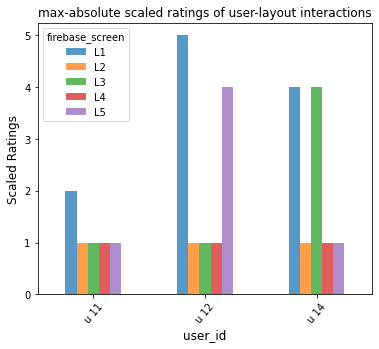

In [29]:
fig, ax = plt.subplots(figsize=(6,5))
plt.xlabel("User id", fontsize=12)
plt.ylabel("Scaled Ratings", fontsize=12)
result_plot = result[result.scaling_ratings>0].groupby(['user_id','firebase_screen']).sum()['scaling_ratings']
result_plot.unstack().plot(kind = 'bar',ax=ax,alpha=0.75, rot=50,title="max-absolute scaled ratings of user-layout interactions")

- outliers detection, standardization and normalization before scaling weights
    - above most of the ratings given by users to layouts is less than zero that is why we can apply zscore and IQR techniques 
    before scaling it using max-absolute and min-max scalers

In [30]:
result['standardized_ratings_Zscore'] = (result.weights - result.weights.mean())/result.weights.std(ddof=0) 
result['outliers'] = (abs((result.standardized_ratings_Zscore>3)|(result.standardized_ratings_Zscore<-3))).astype(int)
result.loc[(result.outliers!=1),:].head()

,user_id,firebase_screen,weights,scaling_ratings,standardized_ratings_Zscore,outliers
0,u 2,L1,158.674,0.0,-0.336444,0
1,u 2,GLHS1,43.597,0.0,-0.403314,0
2,u 3,L1,91.978,0.0,-0.375200,0
3,u 3,L5,91.349,0.0,-0.375566,0
4,u 2,GLHS2,2.701,0.0,-0.427078,0


- max absolute scaler on standardized weights

C:\Users\MUHAMM~1\AppData\Local\Temp/ipykernel_22684/1259907509.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  result.sacling_ratings_after_zscore = round(result.scaling_ratings_after_zscore,0)


<AxesSubplot:title={'center':'scaled ratings using max absolute after removing outliers using Z-score'}, xlabel='user_id', ylabel='Scaled Ratings'>

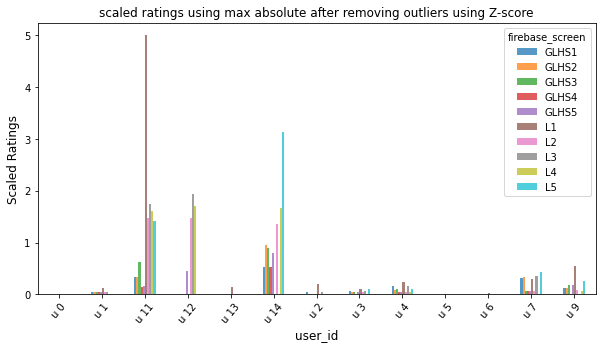

In [31]:
result['scaling_ratings_after_zscore'] = 5 * result.loc[(result.outliers!=1),'weights'] / result.loc[(result.outliers!=1),'weights'].max()
result.sacling_ratings_after_zscore = round(result.scaling_ratings_after_zscore,0)
fig, ax = plt.subplots(figsize=(10,5))
plt.xlabel("User id", fontsize=12)
plt.ylabel("Scaled Ratings", fontsize=12)
result_plot = result[result.scaling_ratings_after_zscore>0].groupby(['user_id','firebase_screen']).sum()['scaling_ratings_after_zscore']
result_plot.unstack().plot(kind = 'bar',ax=ax,alpha=0.75, rot=50,title="scaled ratings using max absolute after removing outliers using Z-score")

- IQR
    - detecting and removing outliers then scaling weights with max absolute
    - 25% lower and 75% upper IQR 

In [32]:
q1 = result.weights.quantile(q=0.25)
q3 = result.weights.quantile(q=0.75)
irq_values = q3 - q1
irq_values
lower_bound = q1-(1.5 * irq_values)
upper_bound = q3+(1.5 * irq_values)
print(lower_bound,upper_bound)
result['weights_IQR'] = result.loc[~(result.weights<lower_bound)&~(result.weights>upper_bound),'weights']

-560.680125 1050.5168749999998


- scaling weights_IQR feature

<AxesSubplot:title={'center':'scaled ratings using max absolute scaler after removing outliers using IQR'}, xlabel='user_id', ylabel='Scaled Ratings'>

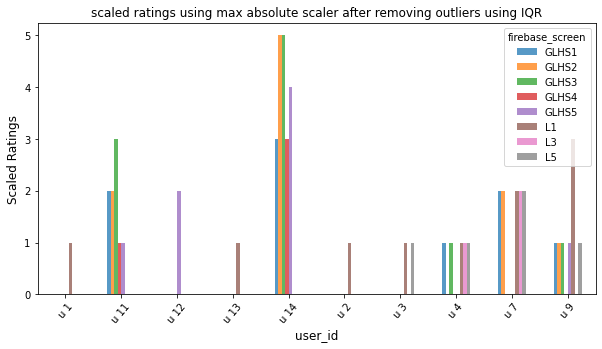

In [33]:
result['scaling_ratings_after_IQR'] = 5 * result.weights_IQR / result.weights_IQR.max()
result.scaling_ratings_after_IQR = round(result.scaling_ratings_after_IQR,0)
fig, ax = plt.subplots(figsize=(10,5))
plt.xlabel("User id", fontsize=12)
plt.ylabel("Scaled Ratings", fontsize=12)
result_plot = result[result.scaling_ratings_after_IQR>0].groupby(['user_id','firebase_screen']).sum()['scaling_ratings_after_IQR']
result_plot.unstack().plot(kind = 'bar',ax=ax,alpha=0.75, rot=50,title="scaled ratings using max absolute scaler after removing outliers using IQR")

- weight feature scaling using min-max (mm)

<AxesSubplot:title={'center':'scaled ratings using min-max scaler'}, xlabel='user_id', ylabel='Scaled Ratings '>

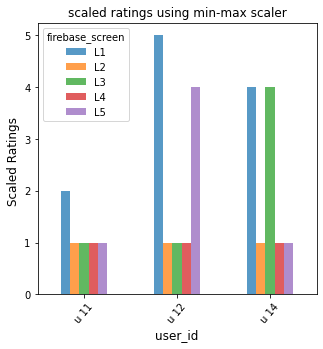

In [34]:
result['scaled_ratings_mm'] = (result.weights-result.weights.min())*5/((result.weights.max())-(result.weights.min()))
result.scaled_ratings_mm = round(result.scaled_ratings_mm,0)
fig, ax = plt.subplots(figsize=(5,5))
plt.xlabel("User id", fontsize=12)
plt.ylabel("Scaled Ratings ", fontsize=12)
result_plot = result[result.scaled_ratings_mm>0].groupby(['user_id','firebase_screen']).sum()['scaled_ratings_mm']
result_plot.unstack().plot(kind = 'bar',ax=ax,alpha=0.75, rot=50,title="scaled ratings using min-max scaler")

- min-max scaling after excluding outliers (z-score)

<AxesSubplot:title={'center':'scaled ratings using min-max after removing outliers using Zscore'}, xlabel='user_id', ylabel='Scaled Ratings'>

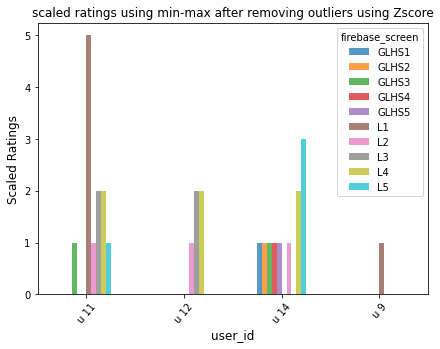

In [35]:
result['scaled_ratings_mm_zscore'] = 5 * (result.loc[(result.outliers!=1),'weights']-result.loc[(result.outliers!=1),'weights'].min())/(result.loc[(result.outliers!=1),'weights'].max()-result.loc[(result.outliers!=1),'weights'].min())
result.scaled_ratings_mm_zscore = round(result.scaled_ratings_mm_zscore,0)
fig, ax = plt.subplots(figsize=(7,5))
plt.xlabel("User id", fontsize=12)
plt.ylabel("Scaled Ratings", fontsize=12)
result_plot = result[result.scaled_ratings_mm_zscore>0].groupby(['user_id','firebase_screen']).sum()['scaled_ratings_mm_zscore']
result_plot.unstack().plot(kind = 'bar',ax=ax,alpha=0.75, rot=50,title="scaled ratings using min-max after removing outliers using Zscore")

- min-maxx scaling after excluding outliers detected by using IQR

<AxesSubplot:title={'center':'scaled ratings using min-max after removing outliers using IQR'}, xlabel='user_id', ylabel='Scaled Ratings'>

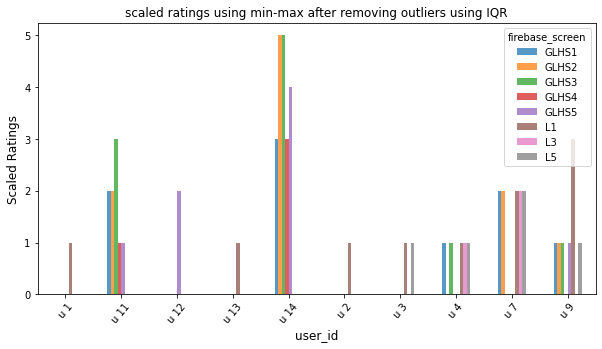

In [36]:
result['scaled_ratings_mm_iqr'] = 5 * (result.weights_IQR-result.weights_IQR.min())/(result.weights_IQR.max()-result.weights_IQR.min())
result.scaled_ratings_mm_iqr = round(result.scaled_ratings_mm_iqr,0)
fig, ax = plt.subplots(figsize=(10,5))
plt.xlabel("User id", fontsize=12)
plt.ylabel("Scaled Ratings", fontsize=12)
result_plot = result[result.scaled_ratings_mm_iqr>0].groupby(['user_id','firebase_screen']).sum()['scaled_ratings_mm_iqr']
result_plot.unstack().plot(kind = 'bar',ax=ax,alpha=0.75, rot=50,title="scaled ratings using min-max after removing outliers using IQR")

### comparing both resuts

In [37]:
result.head()

,user_id,firebase_screen,weights,scaling_ratings,standardized_ratings_Zscore,outliers,scaling_ratings_after_zscore,weights_IQR,scaling_ratings_after_IQR,scaled_ratings_mm,scaled_ratings_mm_zscore,scaled_ratings_mm_iqr
0,u 2,L1,158.674,0.0,-0.336444,0,0.191740,158.674,1.0,0.0,0.0,1.0
1,u 2,GLHS1,43.597,0.0,-0.403314,0,0.052682,43.597,0.0,0.0,0.0,0.0
2,u 3,L1,91.978,0.0,-0.375200,0,0.111145,91.978,1.0,0.0,0.0,1.0
3,u 3,L5,91.349,0.0,-0.375566,0,0.110385,91.349,1.0,0.0,0.0,1.0
4,u 2,GLHS2,2.701,0.0,-0.427078,0,0.003264,2.701,0.0,0.0,0.0,0.0


- comparing resultant scaled ratings 
    - max absolute scaler
    - min-max scaler
    - computed weights feature

c:\Users\Muhammad Shehzad\Documents\vs_code_work_space\.myThesis\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
c:\Users\Muhammad Shehzad\Documents\vs_code_work_space\.myThesis\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
c:\Users\Muhammad Shehzad\Documents\vs_code_work_space\.myThesis\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col()

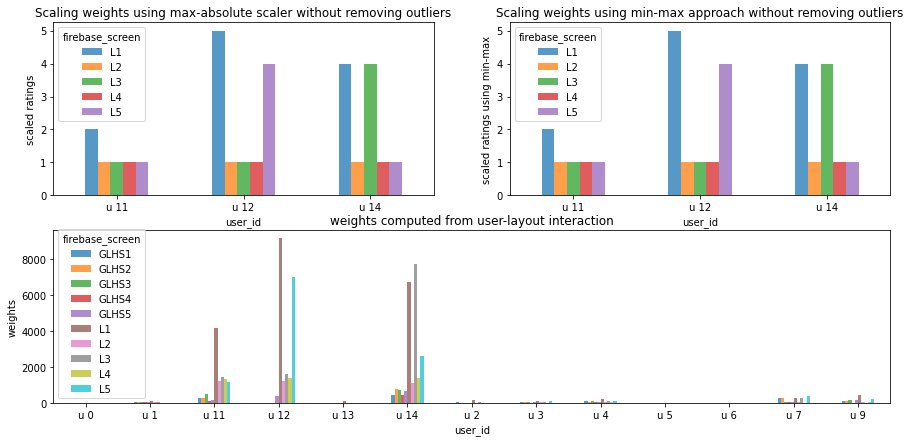

In [38]:
# 'scaling_ratings','scaled_ratings_mm'
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)
plt.xlabel('user_id')
ax1.set_ylabel('scaled ratings')
ax2.set_ylabel('scaled ratings using min-max')
ax3.set_ylabel('weights')

plot_result = result[(result.scaling_ratings>0)].groupby(['user_id','firebase_screen']).sum()['scaling_ratings']
plot_result.unstack().plot(kind = 'bar',ax=ax1,alpha=0.75, rot=360, title='Scaling weights using max-absolute scaler without removing outliers')

plot_result = result[(result.scaled_ratings_mm>0)].groupby(['user_id','firebase_screen']).sum()['scaled_ratings_mm']
plot_result.unstack().plot(kind = 'bar',ax=ax2,alpha=0.75, rot=360, title='Scaling weights using min-max approach without removing outliers')

plot_result = result[(result.weights>0)].groupby(['user_id','firebase_screen']).sum()['weights']
plot_result.unstack().plot(kind = 'bar',ax=ax3,alpha=0.75, rot=360, title='weights computed from user-layout interaction')

plt.show()

c:\Users\Muhammad Shehzad\Documents\vs_code_work_space\.myThesis\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
c:\Users\Muhammad Shehzad\Documents\vs_code_work_space\.myThesis\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
c:\Users\Muhammad Shehzad\Documents\vs_code_work_space\.myThesis\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col()

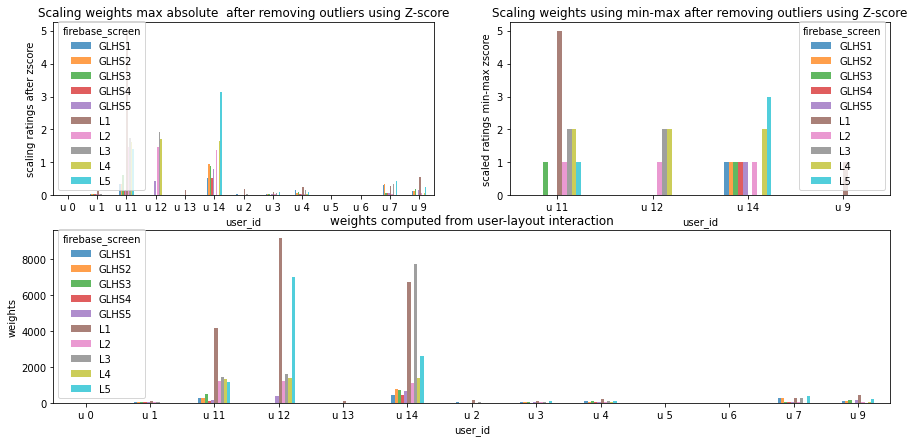

In [39]:
# 'max absolute scaling_ratings_after_zscore','scaled_ratings_mm_zscore', 'weights'
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)
plt.xlabel('user_id')
ax1.set_ylabel('scaling ratings after zscore')
ax2.set_ylabel('scaled ratings min-max zscore')
ax3.set_ylabel('weights')

plot_result = result[(result.scaling_ratings_after_zscore>0)].groupby(['user_id','firebase_screen']).sum()['scaling_ratings_after_zscore']
plot_result.unstack().plot(kind = 'bar',ax=ax1,alpha=0.75, rot=360, title='Scaling weights max absolute  after removing outliers using Z-score')

plot_result = result[(result.scaled_ratings_mm_zscore>0)].groupby(['user_id','firebase_screen']).sum()['scaled_ratings_mm_zscore']
plot_result.unstack().plot(kind = 'bar',ax=ax2,alpha=0.75, rot=360, title='Scaling weights using min-max after removing outliers using Z-score')

plot_result = result[(result.weights>0)].groupby(['user_id','firebase_screen']).sum()['weights']
plot_result.unstack().plot(kind = 'bar',ax=ax3,alpha=0.75, rot=360, title='weights computed from user-layout interaction')

plt.show()

- comparing reults after removing Outliers using IQR
    - max-absolute scaler 
    - min-max scaler

c:\Users\Muhammad Shehzad\Documents\vs_code_work_space\.myThesis\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
c:\Users\Muhammad Shehzad\Documents\vs_code_work_space\.myThesis\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
c:\Users\Muhammad Shehzad\Documents\vs_code_work_space\.myThesis\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col()

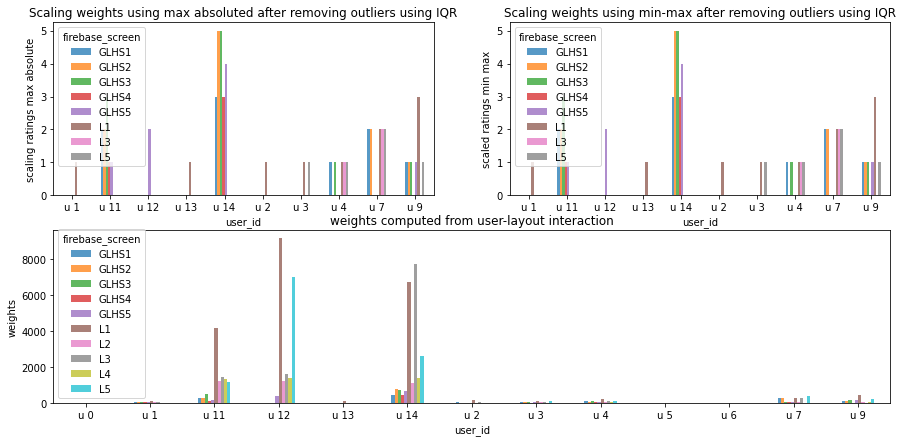

In [40]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)
plt.xlabel('user_id')
ax1.set_ylabel('scaling ratings max absolute')
ax2.set_ylabel('scaled ratings min max')
ax3.set_ylabel('weights')

plot_result = result[(result.scaling_ratings_after_IQR>0)].groupby(['user_id','firebase_screen']).sum()['scaling_ratings_after_IQR']
plot_result.unstack().plot(kind = 'bar',ax=ax1,alpha=0.75, rot=360, title='Scaling weights using max absoluted after removing outliers using IQR')

plot_result = result[(result.scaled_ratings_mm_iqr>0)].groupby(['user_id','firebase_screen']).sum()['scaled_ratings_mm_iqr']
plot_result.unstack().plot(kind = 'bar',ax=ax2,alpha=0.75, rot=360, title='Scaling weights using min-max after removing outliers using IQR')

plot_result = result[(result.weights>0)].groupby(['user_id','firebase_screen']).sum()['weights']
plot_result.unstack().plot(kind = 'bar',ax=ax3,alpha=0.75, rot=360, title='weights computed from user-layout interaction')

plt.show()

- No difference with and without z-score
    - weight-max scaling approad
    - min-max weight scaling approach
- outliers
    - difference between the IQR and Z-score exists
        - Z-score is used to standardize the weights in the range of +3 and -3 standard deviation from mean weights
        - IQR is used to filter the weights form a range we used 25% and 75% quartileRanges to select the examples
- Final Data
    - using IQR we collected maximum users' point of view about the layouts 

<AxesSubplot:xlabel='weights', ylabel='Density'>

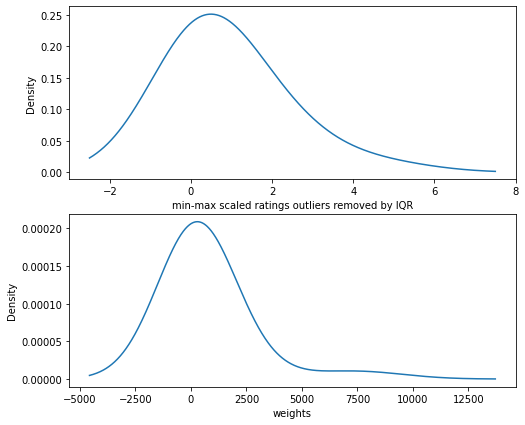

In [41]:
fig = plt.figure(figsize=(8,7))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.set_xlabel('min-max scaled ratings outliers removed by IQR')
ax2.set_xlabel('weights')

result.scaled_ratings_mm_iqr.plot.kde(bw_method=1, ax=ax1)
result.weights.plot.kde(bw_method=1, ax=ax2)

- pivot table for sparsity checking

In [42]:
result = result.rename(columns={'firebase_screen':'layout_id','scaled_ratings_mm_iqr':'ratings'})
result=result.reset_index(drop=True)
result.ratings.replace(0, np.nan, inplace=True)
result = result.loc[(result['ratings']>=1),['user_id','layout_id','ratings']]
result.head()

,user_id,layout_id,ratings
0,u 2,L1,1.0
2,u 3,L1,1.0
3,u 3,L5,1.0
9,u 4,L5,1.0
11,u 4,L1,1.0


In [43]:
Ratings = result.pivot(
    index='user_id', 
    columns='layout_id', 
    values='ratings'
)
Ratings = Ratings.fillna(0).values
print('type ',type(Ratings))
print('shape ',Ratings.shape)
print('Ratings:\n',Ratings)

type  <class 'numpy.ndarray'>
shape  (10, 8)
Ratings:
 [[0. 0. 0. 0. 0. 1. 0. 0.]
 [2. 2. 3. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [3. 5. 5. 3. 4. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 0. 1. 1. 1.]
 [2. 2. 0. 0. 0. 2. 2. 2.]
 [1. 1. 1. 0. 1. 3. 0. 1.]]


In [44]:
sparsity = float(len(Ratings.nonzero()[0]))
sparsity /= (Ratings.shape[0] * Ratings.shape[1])
sparsity *= 100
print('{:.2f}%'.format(sparsity))

40.00%


## Making Recommendations
- before making recommendations first task is to predict the misisng ratings of layouts
- both models predict the ratings before making recommendations of layouts to individual user
    - algorithms : Item based collaborative filtering and matrix factorization techniques for implementing CF
    -  implementation and explaination in: item_based_CB.ipynb and matrixFactorizationModel.ipynb 
- Here we assign ranks to the popular items
    - not discussed in thesis report
    - so only code is available

In [45]:
print("Ratings shape: {}".format(Ratings.shape))
result.to_csv('normalized_data.csv',index=False)
print("result ratings mean(): {}".format(result.ratings.mean()))

Ratings shape: (10, 8)
result ratings mean(): 1.84375


## ranking popular layouts
- assigning mean as new rating to each user-layout interaction

In [46]:
def get_popular_items(n):
    recs = {}
    popular_layouts = result.groupby(['layout_id'])['user_id'].count().reset_index()
    popular_layouts.rename(columns={'user_id':'score'},inplace=True)
    popular_layouts = popular_layouts.sort_values(['score','layout_id'],ascending=[0,1])
    popular_layouts['Rank'] = popular_layouts.score.rank(ascending = 0, method = 'first')
    for index, row in popular_layouts.iterrows():
        recs[row['layout_id']] = {'ratings':result.loc[(result.layout_id==row['layout_id']),'ratings'].mean()}
        #print((rec[row['layout_id']].values())>(result.ratings.mean()))
    sorted_items = sorted(recs.items(), key=lambda item: -float(item[1]['ratings']))
    return sorted_items[:n]
get_popular_items(5)

[('GLHS2', {'ratings': 2.5}),
 ('GLHS3', {'ratings': 2.5}),
 ('GLHS5', {'ratings': 2.0}),
 ('GLHS4', {'ratings': 2.0}),
 ('GLHS1', {'ratings': 1.8})]